In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv("../data/final_output.csv")

# Split features and target
X = data.drop(columns=['selling_price'])
y = data['selling_price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
# Base model
base_model = LinearRegression()
base_model.fit(X_train, y_train)

# Predictions
y_pred = base_model.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
cv_score = cross_val_score(base_model, X, y, cv=5, scoring='r2')

print("Base Model Results:")
print("R²:", r2)
print("RMSE:", rmse)
print("5-Fold CV (Mean R²):", np.mean(cv_score))

Base Model Results:
R²: 0.5194321532589031
RMSE: 167582.68164977548
5-Fold CV (Mean R²): 0.5238142127752934


In [3]:
# 3. Tuned Linear Regression with Normalization
# ---------------------------
# We use a pipeline: StandardScaler + LinearRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

param_grid = {
    'regressor__fit_intercept': [True, False],
    'regressor__positive': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

r2_tuned = r2_score(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
cv_tuned = cross_val_score(best_model, X, y, cv=5, scoring='r2')

print("\n=== Tuned Linear Regression with Normalization ===")
print("Best Parameters:", grid_search.best_params_)
print("R²:", r2_tuned)
print("RMSE:", rmse_tuned)
print("5-Fold CV (Mean R²):", np.mean(cv_tuned))


=== Tuned Linear Regression with Normalization ===
Best Parameters: {'regressor__fit_intercept': True, 'regressor__positive': False}
R²: 0.5194767684030199
RMSE: 167574.90241622517
5-Fold CV (Mean R²): 0.5239145163398361


In [4]:
# Select top 5 features
selector = SelectKBest(score_func=f_regression, k=5)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

# Fit model on selected features
fs_model = LinearRegression()
cv_fs = cross_val_score(fs_model, X_selected, y, cv=5, scoring='r2')
fs_model.fit(X_train[selected_features], y_train)
y_pred_fs = fs_model.predict(X_test[selected_features])

r2_fs = r2_score(y_test, y_pred_fs)
rmse_fs = np.sqrt(mean_squared_error(y_test, y_pred_fs))

print("\nFeature-Selected Model Results:")
print("Selected Features:", list(selected_features))
print("R²:", r2_fs)
print("RMSE:", rmse_fs)
print("5-Fold CV (Mean R²):", np.mean(cv_fs))



Feature-Selected Model Results:
Selected Features: ['car_age', 'year', 'owner', 'km_driven', 'brand_name_Mahindra']
R²: 0.43921173207589137
RMSE: 181030.28713802583
5-Fold CV (Mean R²): 0.454212659078142


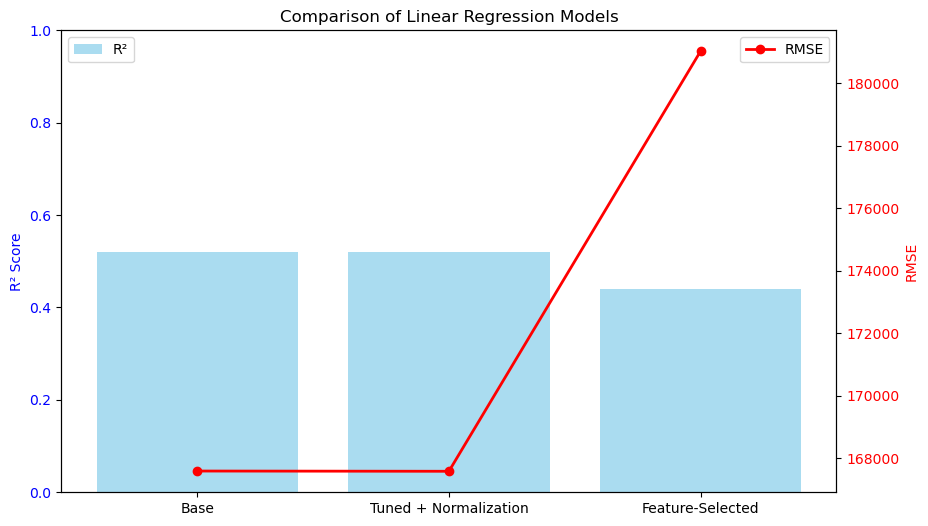

In [9]:
import matplotlib.pyplot as plt

# Make sure these variables are defined from your model code:
# r2_base, r2_tuned, r2_fs
# rmse_base, rmse_tuned, rmse_fs

# If in your code they were named r2, rmse, etc., rename them here:
r2_base = r2
rmse_base = rmse

# r2_tuned, rmse_tuned, r2_fs, rmse_fs should also be defined from your model code

models = ['Base', 'Tuned + Normalization', 'Feature-Selected']
r2_scores = [r2_base, r2_tuned, r2_fs]
rmse_scores = [rmse_base, rmse_tuned, rmse_fs]

fig, ax1 = plt.subplots(figsize=(10,6))

# Bar plot for R²
ax1.bar(models, r2_scores, color='skyblue', alpha=0.7, label='R²')
ax1.set_ylabel('R² Score', color='blue')
ax1.set_ylim(0, 1)
ax1.tick_params(axis='y', labelcolor='blue')

# Line plot for RMSE
ax2 = ax1.twinx()
ax2.plot(models, rmse_scores, color='red', marker='o', linewidth=2, label='RMSE')
ax2.set_ylabel('RMSE', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Comparison of Linear Regression Models')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.savefig("../results/eda_visualizations/IT24103109_Comparison_Linear_Regression_Models.png")
plt.show()


In [6]:
# Model Comparison - Determine Best Model

results = pd.DataFrame({
    'Model': ['Base', 'Tuned + Normalization', 'Feature-Selected'],
    'R2 Score': [r2_base, r2_tuned, r2_fs],
    'RMSE': [rmse_base, rmse_tuned, rmse_fs],
    'Mean CV R2': [np.mean(cv_score), np.mean(cv_tuned), np.mean(cv_fs)]
})

print("\n=== Model Performance Comparison ===")
print(results)

# Find best model based on highest R² and lowest RMSE
best_model_index = results['R2 Score'].idxmax()
best_model_name = results.loc[best_model_index, 'Model']

print(f"\n The most suitable model is: **{best_model_name}**")
print("Reason: It has the highest R² and lowest RMSE, indicating better predictive accuracy.")


=== Model Performance Comparison ===
                   Model  R2 Score           RMSE  Mean CV R2
0                   Base  0.519432  167582.681650    0.523814
1  Tuned + Normalization  0.519477  167574.902416    0.523915
2       Feature-Selected  0.439212  181030.287138    0.454213

 The most suitable model is: **Tuned + Normalization**
Reason: It has the highest R² and lowest RMSE, indicating better predictive accuracy.
